
&nbsp;

# 03 - Validation des anomalies

---

&nbsp;

> #### Les anomalies sont-elles correctement définies et physiquement cohérentes ?

Tout d'abord, rappelons ce que sont les anomalies.

En sciences du climat et en géophysique, une anomalie correspond à l’écart entre une grandeur observée et une valeur de référence, généralement une moyenne climatologique calculée sur une période donnée.

Plus simplement, cela désigne à quel point l’état instantané s’écarte de l’état “normal” du système. En effet, on ne souhaite pas regarder la température en absolue mais plutôt sa déviation par rapport au climat local. C'est donc LE signal pertinent que nous souhaitons capturer.

&nbsp;

---

&nbsp;

## 1. Vérification du biais résiduel

Une première méthode pour détecter des anomalies consiste à calculer le biais résiduel global, une mesure qui reflète le degrée de "centralité" du jeu de donnée. Pour chaque point, on le calcule de la manière suivante : 

&nbsp;

$$
\quad b(x, y, t) = T(x, y, t) - \bar{T}(x, y)
$$

&nbsp;

Avec $ \bar{T}(x, y) $, la moyenne des SST en fonction du temps donnée par : $ \bar{T}(x, y) = \frac{1}{N} \sum_{i=1}^N T_i $. On obtient le biais résiduel en faisant la moyenne de l'ensemble des biais résiduels déterminés en fonction des 3 dimensions, soit :
&nbsp;

$$
B = \frac{1}{N_x N_y N_t} \sum_{x=1}^{N_x} \sum_{y=1}^{N_y} \sum_{t=1}^{N_t} \big( T(x, y, t) - \bar{T}(x, y) \big)
$$
&nbsp;

In [4]:
import xarray as xr
import matplotlib.pyplot as plt

# Load the processed SST dataset

ds = xr.open_dataset("data/processed/sstCOPERNICUS20102019Processed.nc", chunks={"time":365}, decode_times=True)

sst = ds['analysed_sst']

sstMean = sst.mean(dim='time')

sstAnom = sst - sstMean

residualMean = sstAnom.mean(dim=['time', 'latitude', 'longitude'])
print("Biais résiduel global :", residualMean.values)

Biais résiduel global : -3.9189167e-08


On obtient une valeur proche de l'ordre du cent-millionième (~4*10^-8). 

C'est exactement ce que l'on souhaite obtenir car on souhaite que le biais résiduel global tende vers 0 (idéal de centralité du jeu de donnée). Pourquoi ? Car cela signifie que les anomalies sont bien centrées autour de 0, et que par conséquence, aucun décalage systématique ne subsiste dans les données. 

Dans le cas contraire, le modèle que nous allons entraîné pourrait apprendre un décalage inutile, perturbant ainsi la convergence et les prédictions.

En clair, aucun centrage des données n'est nécessaire car le biais résiduel est négligeable devant les fluctuations observées, indiquant que les anomalies sont correctement centrées.

&nbsp;

---

&nbsp;

## 2. Quantifier la variabilité dynamique

La variabilité permet de voir où se passent les signaux forts, et de savoir quelles parties de la donnée sont significatives pour l’apprentissage. 

On parle de variabilité "dynamique", d'une part, car elle évolue dans le temps et l'espace (dû aux 3 dimensions latitude, longitude et temps), et d'autre part, car cette fluctuation de la SST autour de la moyenne locale capture la réponse du système océan-atmosphère aux variations locales et temporelles dûes à des facteurs exogènes (marées, vents, courants côtiers, etc.).

L'outil mathématique de base pour quantifier cette variabilité est l'écart-type en fonction du temps, on le détermine ponctuellement à l'aide de la formule suivante :

&nbsp;

$$
\sigma(x, y) = \sqrt{ \frac{1}{N_t} \sum_{t=1}^{N_t} \big( b(x, y, t) \big)^2 } 
$$

&nbsp;

La variabilité dynamique globale se base sur la même formule mais en fonction des 3 dimensions disponibles pour notre jeu de donnée. Ce qui nous donne la formule suivante :

&nbsp;

$$
\sigma_{\text{globale}} = \sqrt{ \frac{1}{N_x N_y N_t} \sum_{x=1}^{N_x} \sum_{y=1}^{N_y} \sum_{t=1}^{N_t} \big( b(x, y, t) \big)^2 }
$$

&nbsp;

In [2]:
# Global standard deviation (or global dynamic variability)

globalStd = sstAnom.std(dim=['time', 'latitude', 'longitude'])
print("Variabilité dynamique globale :", globalStd.values)

Variabilité dynamique globale : 3.2895494


On obtient une variabilité dynamique globale de ~3.29.

> #### Est-ce raisonnable ?

Après quelques recherches sur les écart-types de références, notre résultat semble plausible. Croisons les résultats de deux rapports pour justifier de la pertinence de ce résultat.

Dans le premier rapport [Sea Surface Temperature Variability: Patterns and Mechanisms](https://staff.cgd.ucar.edu/cdeser/docs/deser.sstvariability.annrevmarsci10.pdf) se basant sur des données de 1982-2008 prenant en compte l'ensemble des zones océaniques du monde, celui-ci présente un écart-type moyen général pour les anomalies de la SST aux alentours des 0.75°-1°(en excluant les régions avec un maximum). Cela nous donne un premier ordre de grandeur à comparer avec notre résultat et nous indique que celui-ci est dans la bonne échelle.

Dans le second rapport [Observations marines, p92-95, de Thierry Lacroix](https://books.openedition.org/editionscnrs/11374) est mentionné le passage suivant : "Sa variabilité dans le temps peut atteindre des valeurs pic à pic de l’ordre de 2 °C pour le cycle diurne (entre le jour et la nuit), de 3 °C pour le cycle saisonnier (entre l’hiver et l’été), de 3 à 4 °C pour la variabilité interannuelle (entre un événement El Niño* et La Niña dans le Pacifique tropical)" (Paragraphe 3).

&nbsp;

Globalement, on affirmera le résultat pertinent pour plusieurs raisons : 
- Les différentes ressources académiques présentent des résultats similaires du nôtre.
- La Manche, caractérisée par une forte proximité aux zones côtières et par des profondeurs relativement faibles, présente des conditions favorables à une variabilité accrue de la température de surface. De nombreux travaux montrent que ces environnements peu profonds réagissent plus rapidement aux forçages atmosphériques, ce qui conduit à une variabilité des anomalies de température de surface supérieure à celle observée en moyenne à l’échelle de l’océan global.

En l'état, on présumera donc que l’ordre de grandeur de la variabilité dynamique est cohérent avec les fluctuations de SST attendues dans une zone côtière tempérée.

/nix/store/7vahi71aq8aphys5h9xyyfif557q92xa-python3-3.12.12-env/lib/python3.12/site-packages/dask/array/numpy_compat.py:61: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


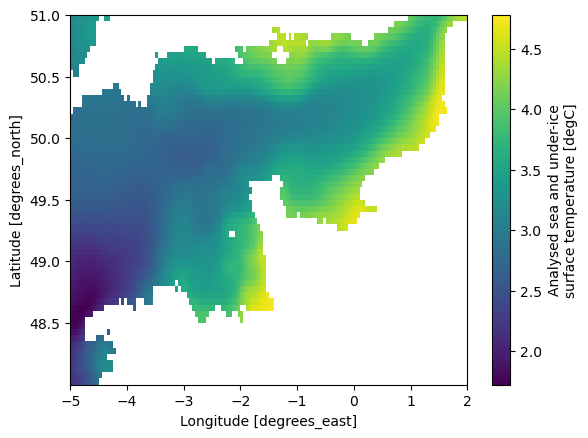

In [3]:
# Standard deviation over time for each grid point

sstStd = sstAnom.std(dim='time')
sstStd.plot() # Plotting it to visualize spatial variability

L’analyse des données confirme par l’observation la plausibilité des hypothèses formulées précédemment. L’écart-type des anomalies de SST apparaît effectivement plus élevé à proximité des zones côtières, en particulier dans la bande littorale la plus étroite, puis décroît progressivement à mesure que l’on s’éloigne vers les zones de haute mer de l’océan Atlantique.

La variabilité plus forte en zone côtière est physiquement cohérente compte tenu des faibles profondeurs et des forçages locaux.

&nbsp;

> #### Que doit-on en conclure ?

Les anomalies de SST sont correctement définies, sans biais résiduel significatif, et présentent une variabilité d’amplitude physiquement réaliste. Leur structure spatiale est cohérente avec la dynamique attendue dans la zone de la Manche. Ces résultats valident l’utilisation de ces anomalies pour la suite de l’analyse statistique et la modélisation SciML.